In [42]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.optim import Adam
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch_geometric.datasets import ZINC
from torch_geometric.nn import VGAE, GCNConv
import matplotlib.pyplot as plt
import numpy as np

from sklearn.mixture import GaussianMixture
import itertools
import pandas as pd 

### Challenges of Graph Generation: 

- A Graph with n nodes can be represented by up to n! equivalent adjacency matrices, each corresponding to a different, arbitrary node ordering. Given that a graph can have multiple representations, it is difficult for the models to calculate
the distance between the generated graphs and groundtruth graphs white training. 
Thus it may require us to design
either a **pre-defined node ordering** or a **node permutation
invariant reconstruction objective function**.

- Two nodes are more likely to be connected if they
share common neighbors. Therefore, the generation of each
node or edge **cannot** be modeled as an independent event

- Large Output space due to n² adjacency matrix 

- Reconstructing the desecrate graph objects (i.e., nodes and
edges) from continuous spaces results into different graph
decoder process, such as sequentially generating the nodes
of the graphs or generating the adjacent matrix of graphs in
one-shot

- Positive Samples (pos_edge_index): These are the actual edges from the graph. The positive loss is calculated based on how well the model predicts the existence of these actual edges, encouraging the model to predict a high probability for the presence of edges that do exist.

- Negative Samples (neg_edge_index): These are pairs of nodes that do not have an edge between them. The negative loss is computed based on how well the model predicts the absence of these non-existent edges, encouraging the model to predict a low probability for the presence of edges that do not exist.

The combined loss function uses both of these components:

- Positive Loss: Aims to minimize the negative log-likelihood of true edges (encouraging the model to assign high probabilities to real connections).
- Negative Loss: Aims to minimize the negative log-likelihood of false edges (encouraging the model to assign low probabilities to non-existent connections).

##### Standard Decoder Architecture: 
compute $\tilde{A}_{i,j}$ based on the inner-product operations of two node embedding $Z_i$
and $Z_j$ . This reflects the idea that nodes that are close in
the embedding space should have a high probability of
being connected

**Use nodes as batches, not graphs
much more flexible**

### The Data generation can be arbitrarily complex, make sure to use multiple graph distributions.

In [145]:
np.random.seed(26)

def gen_data(size=200):
    # Parameters for the Gaussian components
    means = [(-2, -2),
         (0, 0),
         (3, 3)]
    
    covariances = [np.array([[0.5, 0.1],
                         [0.1, 0.5]]),
               np.array([[0.8, -0.2],
                         [-0.2, 0.8]]),
               np.array([[0.3, 0.1],
                         [0.1, 0.3]])]
    
    weights = [0.3, 0.4, 0.3]
    n_samples = size
    
    # Instance: 
    gmm = GaussianMixture(n_components=3, covariance_type='full') 
    # 'full': each component has its own general covariance matrix.
    gmm.means_ = np.array(means)
    gmm.covariances_ = np.array(covariances)
    gmm.weights_ = np.array(weights)
    gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covariances))
    
    data, _ = gmm.sample(n_samples)
    
    temp_x = np.sum(abs(data), axis=1)
    
    # Add Categorical variable: 
    q1 = np.percentile(temp_x , 25)
    q2 = np.percentile(temp_x , 50)
    q3 = np.percentile(temp_x , 75)
    
    def assign_quartile(x, q1, q2, q3):
        if x < q1:
            return 1
        elif x < q2:
            return 2
        elif x < q3:
            return 3
        else:
            return 4
    
    x3 = np.array([assign_quartile(x, q1, q2, q3) for x in temp_x])
    data = np.column_stack((data, x3))#[:,0:3]
    
    return data

data = gen_data(50)

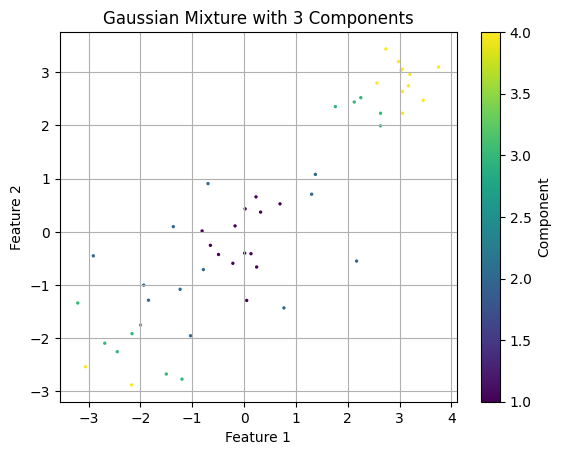

In [146]:
plt.scatter((data[:, 0]), (data[:, 1]), c=data[:, 2], s=2, cmap='viridis')
plt.title('Gaussian Mixture with 3 Components')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.colorbar(label='Component')
plt.show()

In [147]:
def gen_long_df(data):
    idx = list(range(data.shape[0]))
    idx_pairs = list(itertools.combinations(idx, 2))
    
    x1_pairs = list(itertools.combinations(data[:,0], 2))
    x1_delta = [abs(pair[0] - pair[1]) for pair in x1_pairs]
    
    x2_pairs = list(itertools.combinations(data[:,1], 2))
    x2_delta = [abs(pair[0] - pair[1]) for pair in x2_pairs]
    
    x3_pairs = list(itertools.combinations(data[:,2], 2))
    same_x3 = [int(pair[0] == pair[1]) for pair in x3_pairs]
    
    df_long = pd.DataFrame({'idx': idx_pairs, 
                       'x1_delta': x1_delta,
                       'x2_delta': x2_delta, 
                       'same_x3': same_x3
                       })
    return df_long

df_long = gen_long_df(data)

In [155]:
def gen_connectivity(df_long, intercept=10):
    # np.random.seed(26)
    # A low negative intercept means a low default connection probability (all else = 0)
    # Pushing it extremely low, will cause no connections 
    beta_0 = intercept
    
    # Coefficient for x1_delta: the larger the gap, the less likely a connection happens 
    beta_x1 = -4.5 
    # Coefficient for same experience: 1 -> making it more likely to connect 
    beta_x2 = -3.5 
    # Coefficient for same class, 1 -> making it more likely to connect 
    beta_x3 = np.log(1.5)  # increase the odds-ratio by _(whats inside the log)
    
    log_odds = (beta_0 +
                beta_x1 * df_long.x1_delta + 
                beta_x2 * df_long.x2_delta +
                beta_x3 * df_long.same_x3 +
                np.random.normal(0,0.5,df_long.shape[0])) 
    # eps: Changes shape of distribution, larger variance -> clearer bounds
    # Can break indented structure harshly when too high 
    Connection_Prob = 1 / (1 + np.exp(-log_odds))
    
    #df_long["Connection_Prob"] = 1 / (1 + np.exp(-log_odds))
    
    return log_odds, Connection_Prob

log_odds, Connection_Prob = gen_connectivity(df_long)
df_long["Connection_Prob"] = Connection_Prob

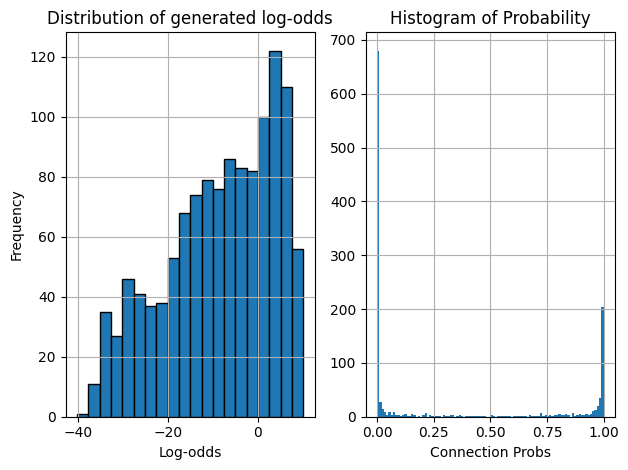

In [149]:
plt.subplot(1, 2, 1)
plt.hist(log_odds, bins= 20, edgecolor='black')
plt.title("Distribution of generated log-odds")
plt.xlabel('Log-odds')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
df_long["Connection_Prob"].hist(bins=100)
plt.title('Histogram of Probability')
plt.xlabel('Connection Probs')

plt.tight_layout()
plt.show()

In [150]:
def gen_graph(data, df_long):

    idx = list(range(data.shape[0]))
    G = nx.Graph()
    G.add_nodes_from(idx,
                     size = data[:,0] + data[:,1])
    
    G.add_edges_from(df_long[df_long['Connection_Prob'] > 
                          np.random.uniform(0,1,
                                            df_long.shape[0])]['idx']
                          )
    return G
    
#print(nx.adjacency_matrix(G).toarray())
#print("Avg. degree in G:",sum(dict(G.degree()).values()) / len(G))
# print("Avg. shortest path:", nx.average_shortest_path_length(G))

In [158]:
def run(R=100):
    graphs = []
    for r in range(R):
        print(r)
        data = gen_data(50)
        df_long = gen_long_df(data)
        log_odds, Connection_Prob = gen_connectivity(df_long, intercept=2)
        df_long["Connection_Prob"] = Connection_Prob
        graph = gen_graph(data, df_long)
    
        graphs.append(graph)
    
    return graphs

res = run(20)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


# *************************************************************

In [5]:
transform = T.Compose([
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=True)
]) # Pipeline of transformations

dataset = ZINC(root='/tmp/ZINC', subset=True, transform=transform)
train_data_list, val_data_list, test_data_list = [], [], []
for train_data, val_data, test_data in dataset:
    try:
        if val_data.neg_edge_label is not None:
            train_data.x = F.normalize(train_data.x.float())
            val_data.x = F.normalize(val_data.x.float())
            test_data.x = F.normalize(test_data.x.float())
            train_data_list.append(train_data)
            val_data_list.append(val_data)
            test_data_list.append(test_data)
    except:
        continue

In [10]:
train_loader = DataLoader(train_data_list, batch_size=100, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=4, shuffle=True)

In [7]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        '''
        :param input_dim: number of node_features
        :param hidden_dim: For Convolution: latent representation of node features 
        :param latent_dim: Dimension of latent embedding z 
        '''
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim) # first layer 
        # Layers for GCN_mu and GCN_sigma
        self.conv_mu = GCNConv(hidden_dim, latent_dim)
        self.conv_logvar = GCNConv(hidden_dim, latent_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        mu = self.conv_mu(x, edge_index)
        # The reason for logvar, is because it yields negative and positive values 
        logvar = self.conv_logvar(x, edge_index)
        return mu, logvar

The encoder (inference model) of VGAE consists of graph convolutional networks (GCNs). It takes an adjacency
matrix A and a feature matrix X as inputs and generates the latent variable Z as output. The first GCN layer
generates a lower-dimensional feature matrix. It is defined as <br>

$$\( \bar{X} \) = GCN(X, A) = ReLU(\( \tilde{A} \)XW_0)$$

$ A \in R^{nxn}$ and $X \in R^{nxf}$, where X is $H^{(0)}$ and $W \in R^{F^{(l)}xF^{(l+1)}}$

A-tilde is the symmetrically normalized adjacency matrix.

$$\tilde{A} = \( D^{-1/2} \)A\( D^{-1/2} \) $$

The second GCN layer generates μ and logσ², where
$$\mu = GCN_{\mu}(X,A) = \( \tilde{A} \)\( \bar{X} \)W_{1}  $$
$$log\sigma² = GCN_{\sigma}(X,A) = \( \tilde{A} \)\( \bar{X} \)W_{1}  $$
Both $\mu$ and log$\sigma$ share the same computation 

Now if we combine the math of two-layer GCN together, we get
...
which generates μ and logσ².

Then we can calculate Z using parameterization trick

$$ Z = \mu + \sigma * \epsilon $$

where ε ~ N(0,1).

In [6]:
class GCNDecoder(torch.nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        ''' Better to only use inner Product layers (MLP)?'''
        super(GCNDecoder, self).__init__()
        self.conv1 = GCNConv(latent_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, z, edge_index):
        x = F.relu(self.conv1(z, edge_index))
        x = torch.sigmoid(self.conv2(x, edge_index))
        return x

#class VGAE(torch.nn.Module):
#    def __init__(self, encoder, decoder):
#        super(VGAE, self).__init__()
#        self.encoder = encoder
#        self.decoder = decoder

#    def reparameterize(self, mu, logvar):
#        if self.training:
#            std = torch.exp(0.5 * logvar) # why *  0.5? 
#            eps = torch.randn_like(std)
#            return mu + eps * std
#        else:
#            return mu

#    def forward(self, x, edge_index):
#        mu, logvar = self.encoder(x, edge_index)
#        z = self.reparameterize(mu, logvar)
#        recon_x = self.decoder(z, edge_index)
#        return recon_x, mu, logvar


In [11]:
def generate_synthetic_graph(num_nodes):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_nodes, latent_dim).to(device)
        edge_index = torch.combinations(torch.arange(num_nodes), r=2).t().to(device)
        recon_x = model.decoder(z, edge_index)
        return recon_x

The degree to which the Auto Encoder simply reproduces the graph, depends on how small the **difference between the number of hidden dimensions and the number of input dimensions** is.

In [13]:
# Configurate: 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model parameters for a smaller dataset
input_dim = dataset.num_node_features
hidden_dim = 16  # Adjusted hidden dimension
latent_dim = 8   # Adjusted latent dimension

# Initialize models with adjusted dimensions
encoder = GCNEncoder(input_dim, hidden_dim, latent_dim).to(device)
decoder = GCNDecoder(latent_dim, hidden_dim, input_dim).to(device)
model = VGAE(encoder, decoder).to(device)

# Optimizer
optimizer = Adam(model.parameters(), lr=0.01)

def train():
    """
    :return: Avg Train Loss for one epoch
    called in the train Loop
    One entire graph is processed at a time 
    """
    model.train()
    loss_all = 0
    i = 0
    for data in train_loader:
        optimizer.zero_grad()
        # model is an instance of the VGAE class.
        # The layers and forward method where passed as inputs to VGAE().
        # def reparametrize(self, mu: Tensor, logstd: Tensor) -> Tensor:
        # if self.training:
        #    return mu + torch.randn_like(logstd) * torch.exp(logstd)
        # else:
        #    return mu
        z = model.encode(data.x, data.edge_index) # only one tensor due to re-parametrize  
        
        # reconstruction loss: use both postive and negative samples (nodes with and without edges)
        # since we want to predict both outcomes: edge or no edge
        loss = model.recon_loss(z, data.pos_edge_label_index, data.neg_edge_label_index)
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        loss_all += data.y.size(0) * float(loss) # (variable) batch size * loss
        optimizer.step()
        
    avg_loss = loss_all / len(train_loader.dataset)
    print(avg_loss)
    

    return avg_loss

@torch.no_grad()
def val(loader):
    model.eval()
    auc_all, ap_all = 0, 0

    for data in loader:
        z = model.encode(data.x, data.edge_index)
        auc, ap = model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)
        auc_all += data.y.size(0) * float(auc)
        ap_all += data.y.size(0) * float(ap)
    return auc_all / len(val_loader.dataset), ap_all / len(val_loader.dataset)

@torch.no_grad()
def test(loader):
    """
    :param loader: test loader
    :return: List of reconstructed Adj. Matrices.
    """
    model.eval()
    graph_adj = []
    for graph, data in enumerate(loader):
        # Model handles Graph size dynamically: why? 
        # Model encode implicitly calls the forward method and returns its output.
        # here: return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
        z = model.encode(data.x, data.edge_index)
        print("size of z: ", z.shape) # out_channels x num_nodes
        recon_mat = model.decoder.forward_all(z)
        print("size of A~: ", recon_mat.shape) # num_nodes x num_nodes 
        graph_adj.append(recon_mat) # append the reconstructed Adj. Matrix
        if graph == gen_graphs - 1: # Condition if enough graphs are generated.
            break
    return graph_adj


In [14]:
for epoch in range(1, 5 + 1):
    loss = train()
    # auc, ap = val(val_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

TypeError: GCNDecoder.forward() got an unexpected keyword argument 'sigmoid'

# Testing

In [24]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch_geometric.datasets import ZINC
from torch_geometric.nn import VGAE, GCNConv
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [25]:
transform = T.Compose([
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=True)
])

#Combines a single transformation step using T.Compose.
#The T.RandomLinkSplit transformation:
#Splits the graph's edges into training (85%), validation (5%), and test (10%) sets.
#Treats the graph as undirected.
#Generates labels for the split edges to indicate whether they are positive or negative samples.
#Adds negative samples to the training set to facilitate link prediction tasks.

dataset = ZINC(root='/tmp/ZINC', subset=True, transform=transform)
train_data_list, val_data_list, test_data_list = [], [], []
for train_data, val_data, test_data in dataset:
    try:
        if val_data.neg_edge_label is not None:
            train_data.x = F.normalize(train_data.x.float())
            val_data.x = F.normalize(val_data.x.float())
            test_data.x = F.normalize(test_data.x.float())
            train_data_list.append(train_data)
            val_data_list.append(val_data)
            test_data_list.append(test_data)
    except:
        continue

In [23]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


In [18]:
in_channels, out_channels, lr, n_epochs = dataset.num_features, 16, 1e-2, 5 # num_features = 1
gen_graphs, threshold, batch_size, add_self_loops = 5, 0.5, 2, True
model = VGAE(VariationalGCNEncoder(in_channels, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=batch_size)